In [67]:
!pip install statsmodels
!pip install pmdarima

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/CSE419/Data Mining.xlsx")

df.head()

#Station No.
a = 2

# Take all rows of Station No. a
b = df.iloc[:,a]

In [71]:
df.describe()

,SW273,SW267,SW269
count,5015.000000,5015.000000,5015.000000
mean,4.971986,8.797886,7.088640
std,1.248850,2.063672,1.233145
min,1.670000,3.140000,3.180000
25%,4.050000,7.730000,6.460000
50%,5.300000,9.510000,7.430000
75%,5.900000,10.340000,7.970000
max,7.780000,12.440000,9.750000


In [72]:
b.isnull().sum()

0

## AdFuller Test  d=0

In [73]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [74]:
res = adfuller(b)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])

ADF Statistic: -9.373889
p-value: 0.000000


In [75]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

Text(0.5, 1.0, 'Original Series')

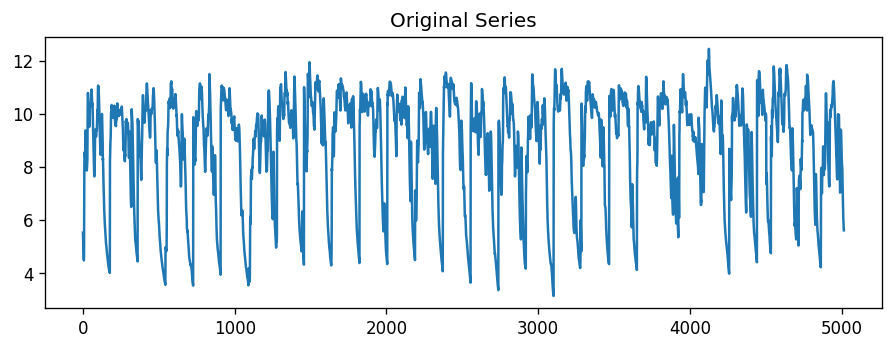

In [76]:
# Original Series
fig, axes = plt.subplots(1, 1, sharex=False)
axes.plot(b); 
axes.set_title(f'Original Series')

## Using PACF, Order of p (AR) is 1

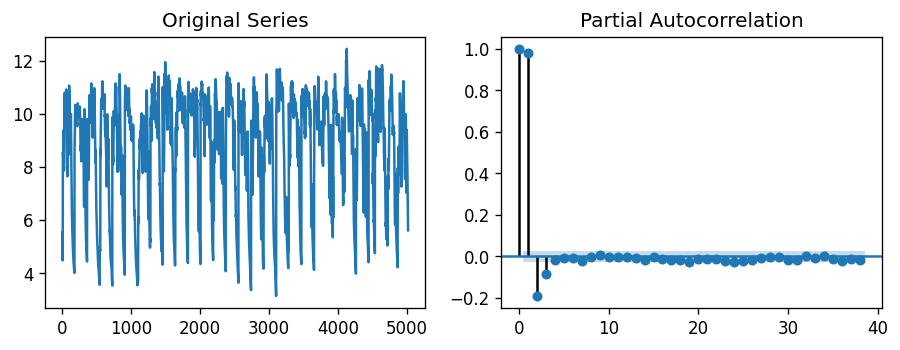

In [77]:
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(b)
axes[0].set_title('Original Series')
plot_pacf(b, ax=axes[1]);

## Using ACF, Order of q (MA) is 1

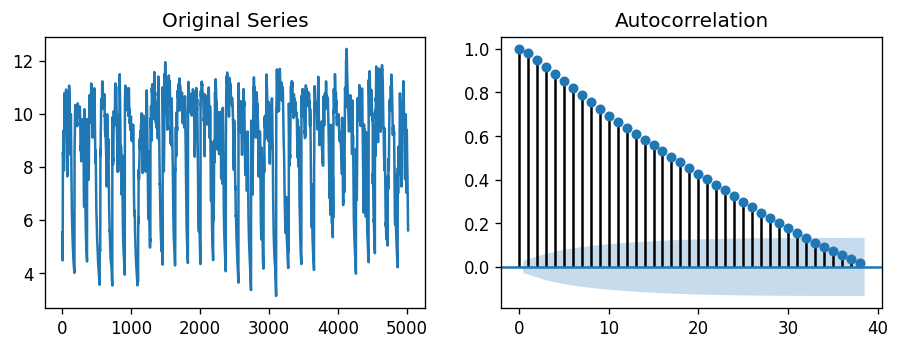

In [78]:
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(b) 
axes[0].set_title('Original Series')
plot_acf(b, ax=axes[1]);

## ARIMA Train

In [79]:
from statsmodels.tsa.arima_model import ARIMA

# 0,1,1
model = ARIMA(b, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  SW267   No. Observations:                 5015
Model:                     ARMA(1, 1)   Log Likelihood               -2613.065
Method:                       css-mle   S.D. of innovations              0.407
Date:                Thu, 09 Sep 2021   AIC                           5234.129
Time:                        07:50:31   BIC                           5260.210
Sample:                             0   HQIC                          5243.269
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.7509      0.252     34.671      0.000       8.256       9.246
ar.L1.SW267     0.9736      0.003    296.784      0.000       0.967       0.980
ma.L1.SW267     0.1656      0.013     12.778    

## Residual Errors

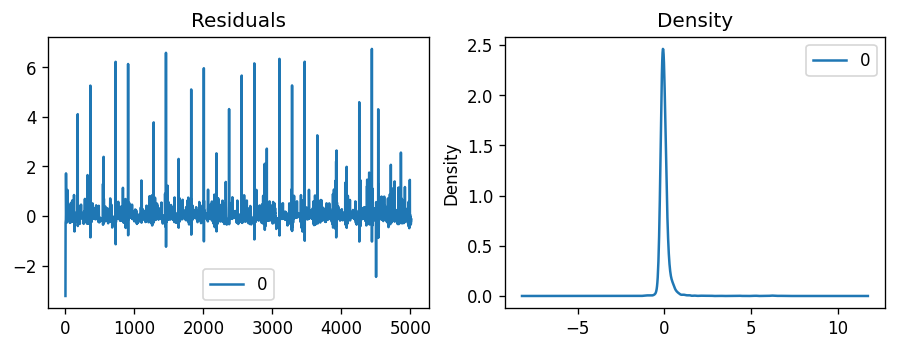

In [80]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## Actual Vs Forecast

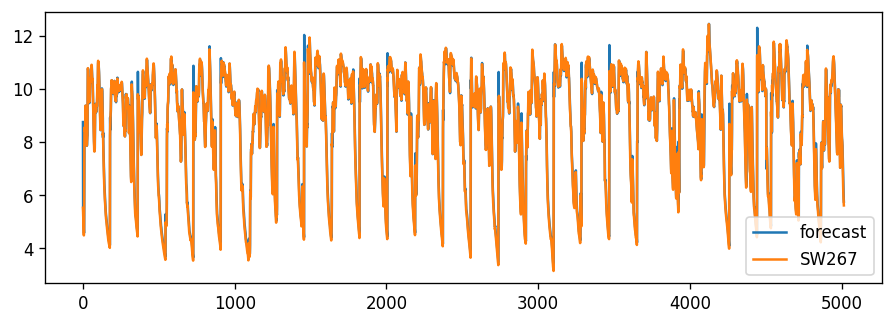

In [81]:
model_fit.plot_predict(dynamic=False)
plt.show()

## Actual Training and Testing Begins

In [82]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = b[:4012]
test = b[4012:]

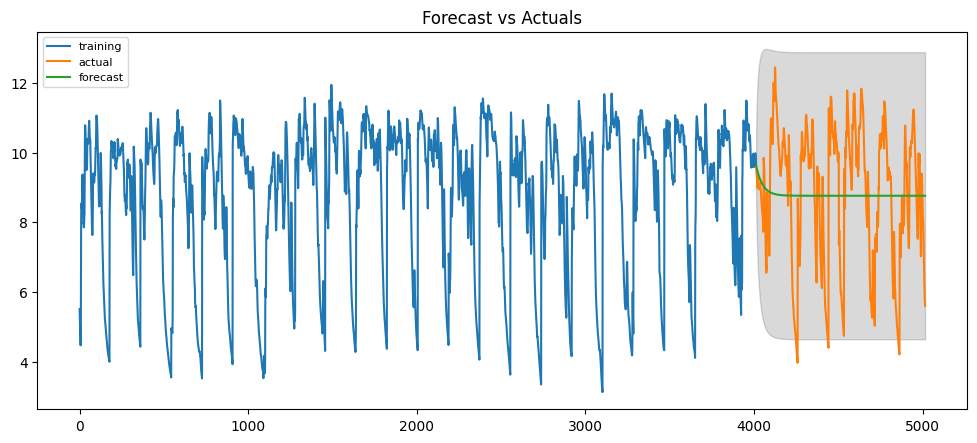

In [83]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(1003, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Evaluation

In [84]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape (%)':mape*100, 'me':me, 'mae': mae, 
            'mpe (%)': mpe*100, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [85]:
forecast_accuracy(fc, test)

{'acf1': 0.9751391572104325,
 'corr': 0.02630290105646684,
 'mae': 1.6177929918644658,
 'mape (%)': 21.494512809075424,
 'me': -0.049629016326838436,
 'minmax': 0.16807135090290404,
 'mpe (%)': 5.739178456122588,
 'rmse': 1.9330718156926985}

## Auto ARIMA

In [86]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model1 = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
# model1 = pm.auto_arima(train,
#                        test='adf',
#                        max_p=3, max_q=3,
#                        m=6,
#                        seasonal=True,   
#                        D=1,
#                        trace=True,
#                        error_action='ignore',  
#                        suppress_warnings=True, 
#                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29046.543, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=23718.327, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4227.106, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4195.936, Time=0.81 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4198.190, Time=0.98 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4196.517, Time=1.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4198.782, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4198.495, Time=1.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4128.513, Time=3.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4177.898, Time=1.35 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4154.921, Time=1.43 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4130

In [87]:
model1.order

(2, 0, 1)

In [88]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4012
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2059.256
Date:                Thu, 09 Sep 2021   AIC                           4128.513
Time:                        07:51:03   BIC                           4159.998
Sample:                             0   HQIC                          4139.672
                               - 4012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1374      0.032      4.351      0.000       0.075       0.199
ar.L1          1.5568      0.074     21.098      0.000       1.412       1.701
ar.L2         -0.5725      0.072     -7.925      0.0

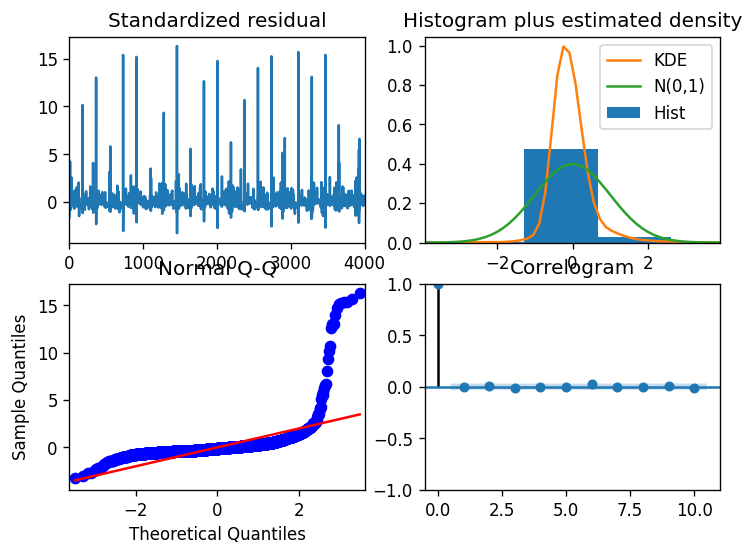

In [89]:
model1.plot_diagnostics(figsize=(7,5))
plt.show()

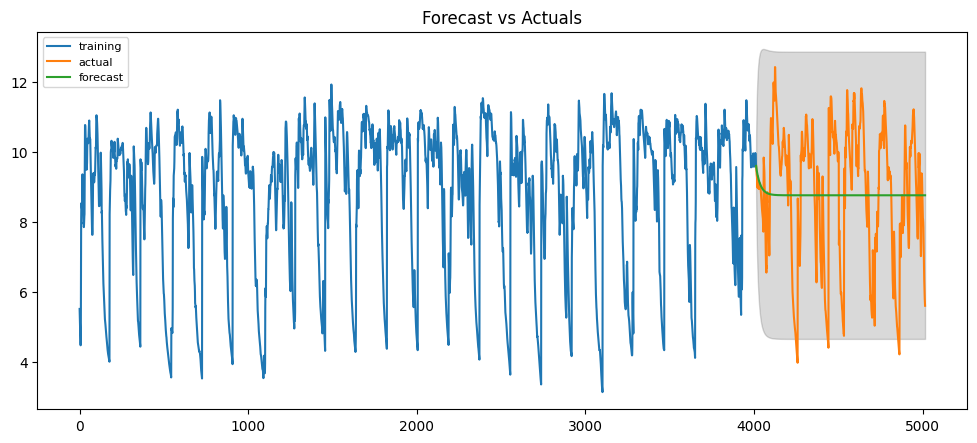

In [103]:
# Forecast
fc1, conf = model1.predict(n_periods=1003, return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc1, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
# plt.show()
plt.savefig('result.png', dpi=400)

In [91]:
# forecast_accuracy(fc, test),  forecast_accuracy(fc1, test)
forecast_accuracy(fc1, test)

{'acf1': 0.9751391572104325,
 'corr': 0.019888794311952337,
 'mae': 1.6122177645216345,
 'mape (%)': 21.436629127687592,
 'me': -0.05478447740569064,
 'minmax': 0.1674610147965675,
 'mpe (%)': 5.686429951397465,
 'rmse': 1.9331127419884195}

In [92]:
i=1000
test.iloc[i], fc1[i], fc[i]

(5.82, 8.770897284083242, 8.763546905718446)

In [93]:
import numpy as np

error = fc - test 
abs_error = np.abs(error)
esd = np.sum((abs_error - np.mean(abs_error))**2)

test_mean = np.mean(test)
fc_mean = np.mean(fc)

r_square_numerator = np.sum((test-test_mean)*(fc-fc_mean))**2
r_square_denominator = np.sum((test-test_mean)**2)*np.sum((fc-fc_mean)**2)
r_square = r_square_numerator / r_square_denominator

esd, r_square

(1122.8710175399883, 0.0006918426039862839)

In [96]:
error1 = fc1 - test 
abs_error1 = np.abs(error1)
mse1 = np.sum(error1**2)
esd1 = np.sum((abs_error1 - np.mean(abs_error1))**2)

test_mean = np.mean(test)
fc1_mean = np.mean(fc1)

r_square_numerator1 = np.sum((test-test_mean)*(fc1-fc1_mean))**2
r_square_denominator1 = np.sum((test-test_mean)**2)*np.sum((fc1-fc1_mean)**2)
r_square1 = r_square_numerator1 / r_square_denominator1

mse1, esd1, r_square1

(3748.1356478577045, 1141.0917892578527, 0.0003955641391831484)

## **FINAL RESULTS**

In [97]:
 dict1 = forecast_accuracy(fc1, test)

In [99]:
dict2 = {**dict1,'mse' : mse1, 'esd': esd1, 'r_square': r_square1}
dict2

{'acf1': 0.9751391572104325,
 'corr': 0.019888794311952337,
 'esd': 1141.0917892578527,
 'mae': 1.6122177645216345,
 'mape (%)': 21.436629127687592,
 'me': -0.05478447740569064,
 'minmax': 0.1674610147965675,
 'mpe (%)': 5.686429951397465,
 'mse': 3748.1356478577045,
 'r_square': 0.0003955641391831484,
 'rmse': 1.9331127419884195}